In [1]:
import scipy
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import seaborn as sns

from src.IterativeFitting import IterativeFitting as IF
from src.CorrFuncs import covariance_matrix, trend_est

#### Example in GL Paper

In [2]:
x = np.array([2,6,11])
Nx = np.array([337,167,186,212])
M1x = 451
Lx = np.array([np.log(0.80),np.log(1.16),np.log(1.57)])
vx = np.array([0.0542,0.0563,0.0563])
A0 = M1x*Nx[1:]/(Nx.sum())

In [3]:
it_fit_ex = IF(Lx,A0,Nx,M1x)

In [4]:
A, B, a0, b0 = it_fit_ex.convexProgram()

In [5]:
A

array([ 70.33038633,  95.48567119, 124.67758726])

In [6]:
a0

160.50635522335585

Create Covariance Matrix

In [7]:
C1 = covariance_matrix(A,B,a0,b0,vx)

In [8]:
C1

array([[0.0542    , 0.01882672, 0.01943165],
       [0.01882672, 0.0563    , 0.02068641],
       [0.01943165, 0.02068641, 0.0563    ]])

In [36]:
sub_C1

array([[0.01882672, 0.0563    ],
       [0.01943165, 0.02068641]])

In [40]:
sub_mask

array([[1., 1.],
       [1., 1.]])

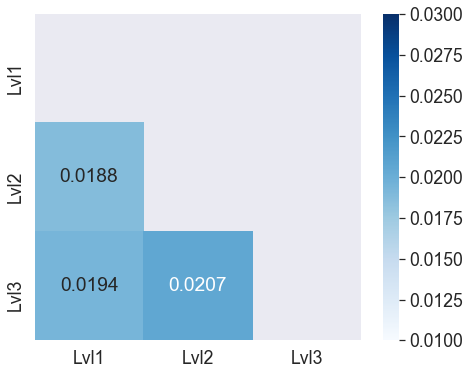

In [61]:
# Use seaborn's heatmap function which has an option to mask parts of the matrix
# sub_C1 = C1[1:, :-1]
# sub_mask = np.triu(np.ones_like(sub_C1, dtype=bool))
# sub_mask = np.zeros_like(sub_C1)
mask = np.triu(np.ones_like(C1, dtype=bool))  # Mask for the upper triangle
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.6)
sns.heatmap(C1, annot=True, mask=mask, cmap='Blues', cbar=True, square=True,  fmt=".4f",
            xticklabels=[f'Lvl{i+1}' for i in range(3)], 
            yticklabels=[f'Lvl{i+1}' for i in range(3)], vmin=.01,vmax=0.03)
# plt.title('Upper Triangle of Covariance Matrix--Convex GL')
plt.savefig("images/Convex_GL_covar.png")
plt.show()

In [31]:
mask

array([[ True,  True,  True],
       [False,  True,  True],
       [False, False,  True]])

In [6]:
A_GL = it_fit_ex.GL()

In [7]:
A_GL

(array([ 70.20458464,  95.46963796, 124.85560373]),
 160.47017367350816,
 array([96.79541536, 90.53036204, 87.14439627]),
 176.52982632649184,
 2)

In [8]:
np.sum(A_GL[0]) + A_GL[1]

451.0

In [25]:
A_GLN = it_fit_ex.GL_linesearch()

In [26]:
A_GLN

(array([ 70.33753879,  95.44494158, 124.66704769]),
 160.55047193677308,
 array([96.66246121, 90.55505842, 87.33295231]),
 176.44952806322692,
 2)

In [27]:
trend_est(A,B,a0,b0,vx,x,Lx,unadj=False)

(0.045430215893878516, 0.0004268215544488761)

#### Example from alochol data in $\verb+dosresmeta+$

In [80]:
x = np.array([9.06,27.,45.,64.8])
Nx = np.array([414,261,228,44,34])
A0 = np.array([61,69,22,19])
M1x = np.sum(A0) + 126
Lx = np.array([-0.2231435,-0.0001,0.5306283,0.8754687])
vx = np.array([0.2233380,0.2337519,0.3765137,0.4440046])
vx *= vx

In [81]:
alcohol_data = IF(Lx,A0,Nx,M1x)

In [82]:
result_alc = alcohol_data.convexProgram()

In [83]:
result_alc

(array([67.12135054, 68.86105977, 18.64972113, 17.32195872]),
 array([193.87864946, 159.13894023,  25.35027887,  16.67804128]),
 125.04590983884529,
 288.9540901611547)

#### RR example where everything works

In [46]:
x = np.array([1.8286, 9.1992, 22.8571, 35.6667, 58.4257])
A = np.array([38., 43., 32., 16., 27.])
a0 = 28
M1 = np.sum(A) + a0
B = np.array([22185.73, 43030.54, 53088.96, 45348.09, 19790.79, 19919.85])
L = np.array([-0.41673, -0.39555, -0.48842, -0.27903, 0.20232])
v = np.array([0.2510976, 0.2456013, 0.2633819, 0.3208115, 0.2861643])
v *= v

In [47]:
RR_ex = IF(L,A,B,M1)

In [48]:
A_GLRR, a0_GLRR, B_GLRR, b0_GLRR, iter_GLRR = RR_ex.GL(OR=False)

In [49]:
A_GLRR

array([33.88106778, 42.96697564, 33.41520852, 17.88177706, 29.21975009])

In [50]:
b_GLRR, se_GLRR = trend_est(A_GLRR,B_GLRR,a0_GLRR,b0_GLRR,v,x,L,unadj=False)

In [51]:
print(b_GLRR, se_GLRR)

0.007131624060147025 1.5176081960353128e-05


In [52]:
A_cvxRR, B_cvxRR, a0_cvxRR, b0_cvxRR = RR_ex.convexProgram(OR=False)

In [53]:
a0_cvxRR

26.59728749176199

In [54]:
A_cvxRR

array([34.00610242, 42.85317043, 33.35834454, 17.94921829, 29.23587682])

In [55]:
b_cvxRR, se_cvxRR = trend_est(A_cvxRR,B_cvxRR,a0_cvxRR,b0_cvxRR,v,x,L,unadj=False)

In [56]:
b_cvxRR

0.007137599341147913

In [57]:
trend_est(A_cvxRR,B_cvxRR,a0_cvxRR,b0_cvxRR,v,x,L,unadj=True)

(0.007137599341147913,
 1.5165650431946001e-05,
 -0.002945971690368591,
 1.5864902051567542e-05)

In [58]:
C2 = covariance_matrix(A_cvxRR,B_cvxRR,a0_cvxRR,b0_cvxRR,v)

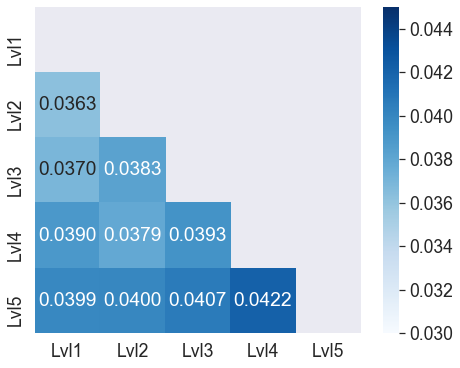

In [63]:
mask = np.triu(np.ones_like(C2, dtype=bool))  # Mask for the upper triangle
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.6)
sns.heatmap(C2, annot=True, mask=mask, cmap='Blues', cbar=True, square=True,  fmt=".4f",
            xticklabels=[f'Lvl{i+1}' for i in range(5)], 
            yticklabels=[f'Lvl{i+1}' for i in range(5)], vmin=.03,vmax=0.045)
# plt.title('Upper Triangle of Covariance Matrix--Convex GL')
plt.savefig("images/Convex_GL_covarRR.png")
plt.show()

Our convex formulation matches EXACTLY with what is in $\verb+dosresmeta+$.

#### OR Example that doesn't work on $\verb+dosresmeta+$ but works for our method

In [3]:
x = np.array([2,6,11])
Nx = np.array([337,167,186,212])
M1x = 451
Lx = np.array([np.log(0.80),np.log(1.16),np.log(1.57)])
vx = np.array([0.0542,0.0563,0.0563])
A0 = Nx[1:] - 1.

In [4]:
alcohol_data_2 = IF(Lx,A0,Nx,M1x)
alcohol_data_2.GL()

/Users/Johnson/Documents/Sasha_Research/CvxFitting/src/IterativeFitting.py:172: RuntimeWarning: invalid value encountered in log
  e = L + np.log(a0) + np.log(B) - np.log(A) - np.log(b0)


ValueError: array must not contain infs or NaNs

In [6]:
alcohol_data_2.convexProgram()

(array([101.12206468, 128.33876093]),
 array([65.87793532, 57.66123907]),
 221.5391743924633,
 115.46082560753669)

As we can see here, our method is working when their method doesn't work. Notice we don't have to give any initial guess. As such, we do not need to know any crude observed totals for the cases initially.

#### Grid values where it works vs when it doesn't work

In [17]:
x = np.array([2,6])
Nx = np.array([337,167,186,212])
M1x = 451
Lx = np.array([np.log(0.80),np.log(1.16),np.log(1.57)])
A0 = np.array([74,90,122])

In [46]:
x,y = np.meshgrid(np.arange(1,Nx[1],1),np.arange(1,Nx[2],1))
A0_vals = np.vstack([x.flatten(),y.flatten()]).T*1.
z = np.array([122 for _ in range(A0_vals.shape[0])])
z = np.array([z]).T
A0_vals = np.hstack((A0_vals,z))
failed_A0=[]
succeeded_A0 = []
for i in range(len(A0_vals)):
    alcohol_data_2 = IF(Lx,A0_vals[i],Nx,M1x)
    try:
        alcohol_data_2.GL()
        succeeded_A0+=[A0_vals[i]]
    except:
        failed_A0+=[A0_vals[i]]

/Users/Johnson/Documents/Sasha_Research/CvxFitting/src/IterativeFitting.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  c0 = 1/a0 + 1/b0
/Users/Johnson/Documents/Sasha_Research/CvxFitting/src/IterativeFitting.py:172: RuntimeWarning: divide by zero encountered in log
  e = L + np.log(a0) + np.log(B) - np.log(A) - np.log(b0)
/Users/Johnson/Documents/Sasha_Research/CvxFitting/src/IterativeFitting.py:172: RuntimeWarning: invalid value encountered in log
  e = L + np.log(a0) + np.log(B) - np.log(A) - np.log(b0)


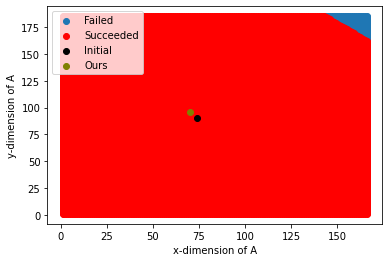

In [50]:
failed_A0 = np.array(failed_A0)
succeeded_A0=np.array(succeeded_A0)
plt.scatter(failed_A0[:,0],failed_A0[:,1],label="Failed")
plt.scatter(succeeded_A0[:,0],succeeded_A0[:,1],c='red',label="Succeeded")
plt.scatter(A0[0],A0[1],c='black',label="Initial")
plt.scatter(alcohol_data_2.convexProgram()[0][0],alcohol_data_2.convexProgram()[0][1],c='olive',label="Ours")
plt.xlabel("x-dimension of A")
plt.ylabel("y-dimension of A")
plt.legend(loc="upper left")

#### Grid Search on N vector

In [341]:
x = np.array([9.06,27.,45.,64.8])
# Nx = np.array([414,261,228,44,34])
A = np.array([126,61,69,22,19])
Nx = A + 2.
# A = Nx - 5.
# A0 = A[1:]
# A0 = np.array([61,69,22,19]) + 0.
M1x = np.sum(A)
A0 = M1x*Nx[1:]/(Nx.sum())
# A0 = A[1:] + 0.
# Lx = np.array([-0.2231435,-0.0001,0.5306283,0.8754687])
Lx = np.array([-200,-250,-300,-700])
vx = np.array([0.2233380,0.2337519,0.3765137,0.4440046])

In [342]:
A0

array([60.94788274, 68.68729642, 23.21824104, 20.31596091])

In [343]:
IF(Lx,A0,Nx,M1x).GL()

(array([   1.77769239, -109.86512984,  -74.9522335 , -330.28627809]),
 810.3259490428073,
 array([ 61.22230761, 180.86512984,  98.9522335 , 351.28627809]),
 -682.3259490428073,
 2)

In [344]:
IF(Lx,A0,Nx,M1x).convexProgram()

(array([62.9999995 , 70.99999944, 23.99999981, 10.99999988]),
 array([5.00201146e-07, 5.64836782e-07, 1.86621818e-07, 1.00000001e+01]),
 128.00000136865125,
 -1.368651254551878e-06)

#### Covariance matrix for broken case

In [84]:
x = np.array([9.06,27.,45.,64.8])
Nx = np.array([414,261,228,44,34])
Nx[0] = 127
Nx[1:] = A0 + 1
A0 = np.array([61,69,22,19])
M1x = np.sum(A0) + 126
Lx = np.array([-0.2231435,-0.0001,0.5306283,0.8754687])
vx = np.array([0.2233380,0.2337519,0.3765137,0.4440046])
vx *= vx
# vx = np.array([0.001,0.01,0.2,0.9])

In [85]:
alcohol_data = IF(Lx,A0,Nx,M1x)
A_alc, B_alc, a0_alc, b0_alc = alcohol_data.convexProgram()

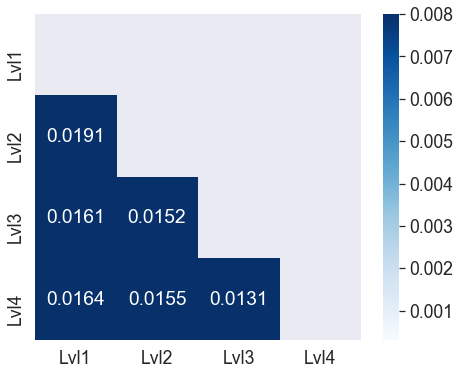

In [86]:
C4 = covariance_matrix(A_alc,B_alc,a0_alc,b0_alc,vx)
mask = np.triu(np.ones_like(C4, dtype=bool))  # Mask for the upper triangle

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.6)
sns.heatmap(C4, annot=True, fmt=".4f", mask=mask, cmap='Blues', cbar=True, square=True, 
            xticklabels=[f'Lvl{i+1}' for i in range(4)], 
            yticklabels=[f'Lvl{i+1}' for i in range(4)], vmin=.0003,vmax=0.008)
# plt.title('Upper Triangle of Covariance Matrix--Solved Hamling')
plt.savefig("images/GL_break.png")
plt.show()